Code testing for https://github.com/pymc-devs/pymc3/pull/2986

In [16]:
import numpy as np
import pymc3 as pm
import pymc3.distributions.transforms as tr
import theano.tensor as tt
import theano
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline

# Polar transformation
    

In [2]:
# Polar to Cartesian
def backward(y):
    # y = [r, theta]
    x = tt.zeros(y.shape)
    x = tt.inc_subtensor(x[0], y[0]*tt.cos(y[1]))
    x = tt.inc_subtensor(x[1], y[0]*tt.sin(y[1]))
    return x

def forward(x):
    # y = [r, theta]
    y = tt.zeros(x.shape)
    y = tt.inc_subtensor(y[0], tt.sqrt(tt.square(x[0]) + tt.square(x[1])))
    if y[0] != 0:
        if x[1] < 0:
            theta = -tt.arccos(x[0]/y[0])
        else:
            theta = tt.arccos(x[0]/y[0])
    y = tt.inc_subtensor(y[1], theta)
    return y

In [3]:
y = tt.vector('polar')
y.tag.test_value=np.asarray([1., np.pi/2])

In [4]:
f_inv = backward(y)
J, _ = theano.scan(lambda i, f, x: tt.grad(f[i], x),
                       sequences=tt.arange(f_inv.shape[0]),
                       non_sequences=[f_inv, y])

In [5]:
Jacob_f1 = theano.function([y], J)

In [6]:
Jacob_f1(np.asarray([1., np.pi/2]))

array([[ 6.123234e-17, -1.000000e+00],
       [ 1.000000e+00,  6.123234e-17]])

In [7]:
J2 = pm.theanof.jacobian(f_inv, [y])
Jacob_f2 = theano.function([y], J2)
Jacob_f2(np.asarray([1., np.pi/2]))

array([[ 6.123234e-17, -1.000000e+00],
       [ 1.000000e+00,  6.123234e-17]])

In [8]:
%timeit Jacob_f1(np.asarray([1., np.pi/2]))
%timeit Jacob_f2(np.asarray([1., np.pi/2]))

86.5 µs ± 1.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
87 µs ± 1.19 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
class Nealfun(tr.VectorTransform):
    name = "Neal_funnel"

    def backward(self, y):
        x = tt.zeros(y.shape)
        x = tt.inc_subtensor(x[0], y[0] / 3.)
        x = tt.inc_subtensor(x[1:], y[1:] / tt.exp(y[0] / 2))
        return x

    def forward(self, x):
        y = tt.zeros(x.shape)
        y = tt.inc_subtensor(y[0], x[0] * 3.)
        y = tt.inc_subtensor(y[1:], tt.exp(x[0] * 3. / 2) * x[1:])
        return y

In [10]:
y = tt.vector('y')
y.tag.test_value=np.zeros(101)

In [11]:
nealfun = Nealfun()
f_inv = nealfun.backward(y)

J1, _ = theano.scan(lambda i, f, x: tt.grad(f[i], x),
                       sequences=tt.arange(f_inv.shape[0]),
                       non_sequences=[f_inv, y])
Jacob_f1 = theano.function([y], J1)

J2 = pm.theanof.jacobian(f_inv, [y])
Jacob_f2 = theano.function([y], J2)

In [12]:
%timeit Jacob_f1(np.zeros(101))
%timeit Jacob_f2(np.zeros(101))

1.17 ms ± 15.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.2 ms ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Copulas
Background reading http://twiecki.github.io/blog/2018/05/03/copulas/  
More information https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Copula.ipynb

In [13]:
import scipy.stats as st
norm = st.norm()

In [23]:
def norm_cdf(x):
    return x_unif


def copulas_forward_func(nsample, cov, marg1_ppf, marg2_ppf):
    mvnorm = st.multivariate_normal(mean=[0, 0], cov=cov)
    # Generate random samples from multivariate normal with correlation .5
    x = mvnorm.rvs(nsample)
    x_unif = norm.cdf(x)
    x_trans = np.vstack([marg1_ppf(x_unif[:, 0]), marg2_ppf(x_unif[:, 1])]).T
    return x_trans, x_unif, x

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


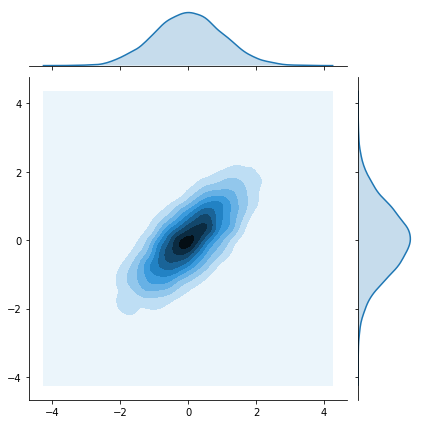

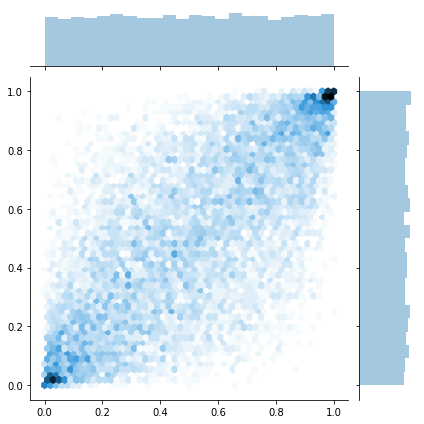

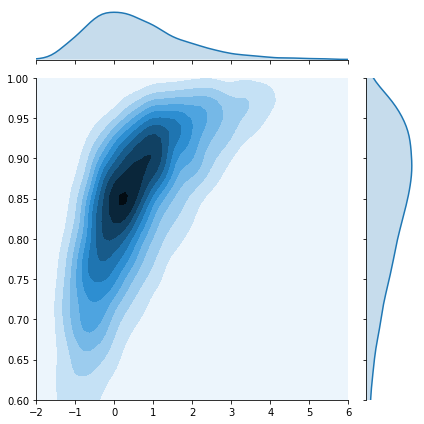

In [42]:
cov = np.asarray([[1., 0.725], [0.725, 1.]])
marg1_ppf = st.gumbel_r().ppf
marg2_ppf = st.beta(a=10, b=2).ppf
x_trans, x_unif, x = copulas_forward_func(10000, cov, marg1_ppf, marg2_ppf)

sns.jointplot(x[:, 0], x[:, 1], kind='kde', stat_func=None)
sns.jointplot(x_unif[:, 0], x_unif[:, 1], kind='hex', stat_func=None, joint_kws=dict(gridsize=50))
sns.jointplot(x_trans[:, 0], x_trans[:, 1], kind='kde', stat_func=None, xlim=(-2, 6), ylim=(.6, 1.0),)
plt.tight_layout();

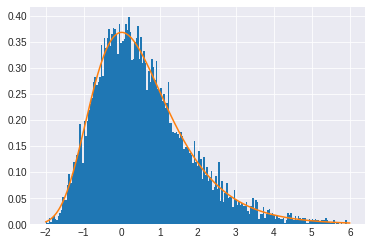

In [47]:
xrange = np.linspace(-2, 6, 200)
plt.hist(x_trans[:, 0], xrange, density='pdf')
plt.plot(xrange, st.gumbel_r.pdf(xrange));

In [50]:
def gumbel_cdf(value, mu, beta):
    return tt.exp(-tt.exp(-(value-mu)/beta))

In [62]:
pm.Beta??

Beta CDF

AttributeError: module 'theano.tensor' has no attribute 'betaln'

In [81]:
max_iter=200
value, a, b = x_trans[:, 1], 10., 2.

EPS = 3.0e-7
qab = a + b
qap = a + 1.0
qam = a - 1.0

def _step(i, az, bm, am, bz):

    tem = i + i
    d = i * (b - i) * value / ((qam + tem) * (a + tem))
    d =- (a + i) * i * value / ((qap + tem) * (a + tem))

    ap = az + d * am
    bp = bz + d * bm

    app = ap + d * az
    bpp = bp + d * bz

    aold = az

    am = ap / bpp
    bm = bp / bpp
    az = app / bpp

    bz = tt.constant(1.0, dtype='float64')

    return (az, bm, am, bz), until(all(abs(az - aold) < (EPS * abs(az))))

(az, bm, am, bz), _ = theano.scan(_step,
            sequences=[tt.arange(1, max_iter)],
            outputs_info=[1., 1., 1., 1. - qab * value / qap])

ValueError: length not known: Elemwise{lt,no_inplace} [id A] ''   
 |Elemwise{abs_,no_inplace} [id B] ''   
 | |Elemwise{sub,no_inplace} [id C] ''   
 |   |Elemwise{true_div,no_inplace} [id D] ''   
 |   | |Elemwise{add,no_inplace} [id E] ''   
 |   | | |Elemwise{add,no_inplace} [id F] ''   
 |   | | | |InplaceDimShuffle{x} [id G] ''   
 |   | | | | |<TensorType(float32, scalar)> [id H]
 |   | | | |Elemwise{mul,no_inplace} [id I] ''   
 |   | | |   |Elemwise{true_div,no_inplace} [id J] ''   
 |   | | |   | |Elemwise{mul,no_inplace} [id K] ''   
 |   | | |   | | |InplaceDimShuffle{x} [id L] ''   
 |   | | |   | | | |Elemwise{mul,no_inplace} [id M] ''   
 |   | | |   | | |   |Elemwise{neg,no_inplace} [id N] ''   
 |   | | |   | | |   | |Elemwise{add,no_inplace} [id O] ''   
 |   | | |   | | |   |   |TensorConstant{10.0} [id P]
 |   | | |   | | |   |   |<TensorType(int64, scalar)> [id Q]
 |   | | |   | | |   |<TensorType(int64, scalar)> [id Q]
 |   | | |   | | |TensorConstant{[0.7949610...80968598]} [id R]
 |   | | |   | |InplaceDimShuffle{x} [id S] ''   
 |   | | |   |   |Elemwise{mul,no_inplace} [id T] ''   
 |   | | |   |     |Elemwise{add,no_inplace} [id U] ''   
 |   | | |   |     | |TensorConstant{11.0} [id V]
 |   | | |   |     | |Elemwise{add,no_inplace} [id W] ''   
 |   | | |   |     |   |<TensorType(int64, scalar)> [id Q]
 |   | | |   |     |   |<TensorType(int64, scalar)> [id Q]
 |   | | |   |     |Elemwise{add,no_inplace} [id X] ''   
 |   | | |   |       |TensorConstant{10.0} [id P]
 |   | | |   |       |Elemwise{add,no_inplace} [id W] ''   
 |   | | |   |InplaceDimShuffle{x} [id Y] ''   
 |   | | |     |<TensorType(float32, scalar)> [id Z]
 |   | | |Elemwise{mul,no_inplace} [id BA] ''   
 |   | |   |Elemwise{true_div,no_inplace} [id J] ''   
 |   | |   |InplaceDimShuffle{x} [id BB] ''   
 |   | |     |<TensorType(float32, scalar)> [id H]
 |   | |Elemwise{add,no_inplace} [id BC] ''   
 |   |   |Elemwise{add,no_inplace} [id BD] ''   
 |   |   | |<TensorType(float64, vector)> [id BE]
 |   |   | |Elemwise{mul,no_inplace} [id BF] ''   
 |   |   |   |Elemwise{true_div,no_inplace} [id J] ''   
 |   |   |   |InplaceDimShuffle{x} [id BG] ''   
 |   |   |     |<TensorType(float32, scalar)> [id BH]
 |   |   |Elemwise{mul,no_inplace} [id BI] ''   
 |   |     |Elemwise{true_div,no_inplace} [id J] ''   
 |   |     |<TensorType(float64, vector)> [id BE]
 |   |InplaceDimShuffle{x} [id BJ] ''   
 |     |<TensorType(float32, scalar)> [id H]
 |Elemwise{mul,no_inplace} [id BK] ''   
   |InplaceDimShuffle{x} [id BL] ''   
   | |TensorConstant{3e-07} [id BM]
   |Elemwise{abs_,no_inplace} [id BN] ''   
     |Elemwise{true_div,no_inplace} [id D] ''   


In [77]:
from theano.scan_module import until


def cont_fraction_beta(value, a, b, max_iter=200):
    '''Evaluates the continued fraction form of the incomplete Beta function.
    Derived from implementation by Ali Shoaib (https://goo.gl/HxjIJx).
    '''

    EPS = 3.0e-7
    qab = a + b
    qap = a + 1.0
    qam = a - 1.0

    def _step(i, az, bm, am, bz):

        tem = i + i
        d = i * (b - i) * value / ((qam + tem) * (a + tem))
        d =- (a + i) * i * value / ((qap + tem) * (a + tem))

        ap = az + d * am
        bp = bz + d * bm

        app = ap + d * az
        bpp = bp + d * bz

        aold = az

        am = ap / bpp
        bm = bp / bpp
        az = app / bpp

        bz = tt.constant(1.0, dtype='float64')

        return (az, bm, am, bz), until(all(abs(az - aold) < (EPS * abs(az))))

    (az, bm, am, bz), _ = theano.scan(_step,
                sequences=[tt.arange(1, max_iter)],
                outputs_info=[1., 1., 1., 1. - qab * value / qap])

    return az[-1]


def beta_cdf(value, a, b):
    log_beta = tt.gammaln(a+b) - tt.gammaln(a) - tt.gammaln(b)
    log_beta += a * tt.log(value) + b * tt.log(1 - value)
    logcdf = tt.switch(
                tt.lt(value, (a + 1) / (a + b + 2)),
                tt.log(tt.exp(log_beta) * cont_fraction_beta(value, a, b) / a),
                tt.log(1. - tt.exp(log_beta) * cont_fraction_beta(1. - value, b, a) / b)
            )
    return tt.exp(logcdf)

In [78]:
def normal_ppf(value):
    return -np.sqrt(2.) * tt.erfcinv(2. * value)

In [79]:
x_ = normal_ppf([gumbel_cdf(x_trans[:, 0], 0., 1.),
                 beta_cdf(x_trans[:, 1], 10., 2.)]).eval()
# sns.jointplot(x_[:, 0], x_[:, 1], kind='kde', stat_func=None);

ValueError: length not known: Elemwise{lt,no_inplace} [id A] ''   
 |Elemwise{abs_,no_inplace} [id B] ''   
 | |Elemwise{sub,no_inplace} [id C] ''   
 |   |Elemwise{true_div,no_inplace} [id D] ''   
 |   | |Elemwise{add,no_inplace} [id E] ''   
 |   | | |Elemwise{add,no_inplace} [id F] ''   
 |   | | | |InplaceDimShuffle{x} [id G] ''   
 |   | | | | |<TensorType(float32, scalar)> [id H]
 |   | | | |Elemwise{mul,no_inplace} [id I] ''   
 |   | | |   |Elemwise{true_div,no_inplace} [id J] ''   
 |   | | |   | |Elemwise{mul,no_inplace} [id K] ''   
 |   | | |   | | |InplaceDimShuffle{x} [id L] ''   
 |   | | |   | | | |Elemwise{mul,no_inplace} [id M] ''   
 |   | | |   | | |   |Elemwise{neg,no_inplace} [id N] ''   
 |   | | |   | | |   | |Elemwise{add,no_inplace} [id O] ''   
 |   | | |   | | |   |   |TensorConstant{10.0} [id P]
 |   | | |   | | |   |   |<TensorType(int64, scalar)> [id Q]
 |   | | |   | | |   |<TensorType(int64, scalar)> [id Q]
 |   | | |   | | |TensorConstant{[0.7949610...80968598]} [id R]
 |   | | |   | |InplaceDimShuffle{x} [id S] ''   
 |   | | |   |   |Elemwise{mul,no_inplace} [id T] ''   
 |   | | |   |     |Elemwise{add,no_inplace} [id U] ''   
 |   | | |   |     | |TensorConstant{11.0} [id V]
 |   | | |   |     | |Elemwise{add,no_inplace} [id W] ''   
 |   | | |   |     |   |<TensorType(int64, scalar)> [id Q]
 |   | | |   |     |   |<TensorType(int64, scalar)> [id Q]
 |   | | |   |     |Elemwise{add,no_inplace} [id X] ''   
 |   | | |   |       |TensorConstant{10.0} [id P]
 |   | | |   |       |Elemwise{add,no_inplace} [id W] ''   
 |   | | |   |InplaceDimShuffle{x} [id Y] ''   
 |   | | |     |<TensorType(float32, scalar)> [id Z]
 |   | | |Elemwise{mul,no_inplace} [id BA] ''   
 |   | |   |Elemwise{true_div,no_inplace} [id J] ''   
 |   | |   |InplaceDimShuffle{x} [id BB] ''   
 |   | |     |<TensorType(float32, scalar)> [id H]
 |   | |Elemwise{add,no_inplace} [id BC] ''   
 |   |   |Elemwise{add,no_inplace} [id BD] ''   
 |   |   | |<TensorType(float64, vector)> [id BE]
 |   |   | |Elemwise{mul,no_inplace} [id BF] ''   
 |   |   |   |Elemwise{true_div,no_inplace} [id J] ''   
 |   |   |   |InplaceDimShuffle{x} [id BG] ''   
 |   |   |     |<TensorType(float32, scalar)> [id BH]
 |   |   |Elemwise{mul,no_inplace} [id BI] ''   
 |   |     |Elemwise{true_div,no_inplace} [id J] ''   
 |   |     |<TensorType(float64, vector)> [id BE]
 |   |InplaceDimShuffle{x} [id BJ] ''   
 |     |<TensorType(float32, scalar)> [id H]
 |Elemwise{mul,no_inplace} [id BK] ''   
   |InplaceDimShuffle{x} [id BL] ''   
   | |TensorConstant{3e-07} [id BM]
   |Elemwise{abs_,no_inplace} [id BN] ''   
     |Elemwise{true_div,no_inplace} [id D] ''   


In [ ]:
with pm.Model() as model:
    # r∼Uniform(−1,1)
    r =  pm.Uniform('r',lower=-1, upper=1)
    
    cov = pm.Deterministic('cov', 
                           tt.stacklists([[1., r],
                                          [r, 1.]]))
    a = pm.HalfNormal('alpha', 5.)
    b = pm.HalfNormal('beta', 2.5)
    loc = pm.Normal('loc', 0., 5.)
    scale = pm.HalfNormal('scale', 2.5)
    
    inverse_val = tt.stack(normal_ppf(gumbel_cdf(x)))
    pm.MvNormal('obs', np.zeros(2), cov=cov, observed=)

In [ ]:
def jacobian_det(f_inv, x):
    J, _ = theano.scan(lambda i, f, x: tt.grad(f[i], x),
                       sequences=tt.arange(f_inv.shape[0]),
                       non_sequences=[f_inv, x])
    return tt.log(tt.abs_(tt.nlinalg.det(J)))